# Inception

get the details fo the colab session

In [3]:
# mount the google drive to the colab session
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!nvidia-smi

Sat Feb  1 02:35:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
!python -V

Python 3.11.11


In [6]:
# !pip install -U datasets
!pip install evaluate
!pip install py7zr

!pip install sacrebleu
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 23.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatib

In [7]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.2.1
aiohappyeyeballs                   2.4.4
aiohttp                            3.11.11
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
ale-py                             0.10.1
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.6.0
arviz                              0.20.0
astropy                            6.1.7
astropy-iers-data                  0.2025.1.27.0.32.44
astunparse                         1.6.3
atpublic                           4.1.0
attrs                              25.1.0
audioread         

In [8]:
# copy data to the colab session
!cp -R "/content/drive/MyDrive/T5_training/data" .

# Import

In [9]:
import os
import os.path as osp
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from datasets import Dataset, DatasetDict

import time
from tqdm import tqdm

from datasets import load_dataset

In [10]:
import nltk
from nltk.tokenize import sent_tokenize

# nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [11]:
# Import the metrics
import evaluate

bleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
import torch
from transformers import pipeline, DataCollatorForSeq2Seq
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import TrainingArguments, Trainer, Seq2SeqTrainingArguments

from transformers import set_seed

In [13]:
seed_value = 5

set_seed(seed_value)
np.random.seed(seed_value)

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Load pre-trained model

In [15]:
# T5-Large model trained on medical literature
model_ckpt = "Falconsai/medical_summarization"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

tokenizer_config.json:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Dataset

In [16]:
# function to read the dataset json file
def read_jsonl(path):
    data = []

    with open(path, 'r', encoding='utf-8') as fd:
        for line in fd:
            line_data = json.loads(line)
            data.append(line_data)

    return data


# create Dataset object from dataframe
def read_dataset(dataset_path):
    data = read_jsonl(dataset_path)
    df = pd.DataFrame(data)
    return df


# function to combine train test, val data in the same object
def create_combined_dataset(train_data_path,
                            val_data_path,
                            test_data_path):

    train_dataset = read_dataset(train_data_path)
    val_dataset = read_dataset(val_data_path)
    test_dataset = read_dataset(test_data_path)

    dataset = DatasetDict({
        "train": Dataset.from_pandas(train_dataset),
        "validation": Dataset.from_pandas(val_dataset),
        "test": Dataset.from_pandas(test_dataset),
    })

    return dataset


In [17]:
data_fol ="/content/data"
train_path = osp.join(data_fol, "train.jsonl")
val_path = osp.join(data_fol, "validate.jsonl")
test_path = osp.join(data_fol, "test.jsonl")

dataset_original = create_combined_dataset(train_path, val_path, test_path)
dataset_original

DatasetDict({
    train: Dataset({
        features: ['idx', 'inputs', 'target'],
        num_rows: 2735
    })
    validation: Dataset({
        features: ['idx', 'inputs', 'target'],
        num_rows: 341
    })
    test: Dataset({
        features: ['idx', 'inputs', 'target'],
        num_rows: 343
    })
})

In [18]:
INPUT_MAX_LENGTH = 1024     # context size of input text
TARGET_MAX_LENGTH = 128     # target output size
INPUT_COLUMN = 'inputs'     # input data column name in the dataset object
TARGET_COLUMN = 'target'    # target data column name in the dataset object

In [19]:
def tokenize_input_and_target_text(batch_row, tokenizer, input_max_length, target_max_length, input_column, target_column):
    # INPUT:
        # batch_row: the text data from the dataframe
        # tokenizer: tokenizer object
        # input_max_length: maximum no of tokens for input text
        # target_max_length: maximum no of tokens for target text
        # input_column: column name for input text
        # target_column: column name for target text

    input_encodings = tokenizer(batch_row[input_column], max_length=input_max_length, truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(batch_row[target_column], max_length=target_max_length, truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"] }


# get the appropriate function to be used to get text encodings
get_text_encodings = partial(tokenize_input_and_target_text,
                             tokenizer=tokenizer,
                             input_max_length=INPUT_MAX_LENGTH,
                             target_max_length=TARGET_MAX_LENGTH,
                             input_column=INPUT_COLUMN,
                             target_column=TARGET_COLUMN)

In [20]:
# get the encodings for both input and target text

dataset = dataset_original.map(get_text_encodings, batched=True)

# filter the required columns for training
columns = ["input_ids", "labels", "attention_mask"]
dataset.set_format(type="torch", columns=columns)
dataset

Map:   0%|          | 0/2735 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/341 [00:00<?, ? examples/s]

Map:   0%|          | 0/343 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'inputs', 'target', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2735
    })
    validation: Dataset({
        features: ['idx', 'inputs', 'target', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 341
    })
    test: Dataset({
        features: ['idx', 'inputs', 'target', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 343
    })
})

# Training

In [21]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [22]:
training_args = Seq2SeqTrainingArguments(
    num_train_epochs=20,
    learning_rate=1e-4,
    weight_decay=0.01,
    output_dir = '/content/out_fol',
    eval_strategy = "epoch",
    save_strategy = 'epoch',
    metric_for_best_model = 'eval_loss',
    logging_steps=43,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=1,
    # save_total_limit=2,
    predict_with_generate=True,
    load_best_model_at_end = True,
    fp16=True,
    seed = seed_value,
    report_to="none"
)


trainer = Trainer(model=model,
                  processing_class=tokenizer,
                  data_collator=data_collator,
                  train_dataset=dataset["train"],
                  eval_dataset=dataset["validation"],
                  args=training_args,)

In [23]:
t1 = time.time()
train_results = trainer.train()
t2 = time.time()

/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,3.010100,1.825220
2,2.232500,1.399036
3,2.010100,1.226545
4,1.882100,1.153295
5,1.784700,1.077193
6,1.711400,1.039204
7,1.663200,1.009721
8,1.615300,0.988359
9,1.582300,0.964419
10,1.541700,0.946511


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


# Evaluate

In [24]:
def evaluate_dataset(dataset,
                     metric,
                     model,
                     tokenizer,
                     batch_size=16,
                     device=device,
                     input_max_length=INPUT_MAX_LENGTH,
                     target_max_length=TARGET_MAX_LENGTH,
                     column_text=INPUT_COLUMN,
                     column_summary=TARGET_COLUMN):
    # INPUT:
        # dataset: the data on which model to be run
        # metric: the metric to compute
        # model: model for summary generation
        # tokenizer: tokenizer model
        # batch_size: the size of the batch
        # device: target device - cuda/cpu
        # input_max_length: maximum no of tokens in input string
        # target_max_length: maximum no of tokens in target string
        # column_text: the key name to get the input text from dataset
        # column_summary: the key name to get the summary text from dataset


    N = len(dataset)

    doc_list=[]
    ref_list=[]
    gen_list=[]

    for i in tqdm(range(0, N, batch_size)):
        j = np.min([i+batch_size, N])

        input_text_batch = dataset[column_text][i:j]
        target_text_batch = dataset[column_summary][i:j]

        input_batch = tokenizer(input_text_batch, max_length=input_max_length, truncation=True, padding="max_length", return_tensors="pt")

        summary_batch = model.generate(input_ids=input_batch["input_ids"].to(device),
                                   attention_mask=input_batch["attention_mask"].to(device), max_length=target_max_length,
                                   length_penalty=0.8, num_beams=8, )

        summaries_decoded = [tokenizer.decode(summary, skip_special_tokens=True, clean_up_tokenization_spaces=True) for summary in summary_batch]

        summaries_decoded = [summary.replace("<n>", " ") for summary in summaries_decoded]
        metric.add_batch(predictions=summaries_decoded, references=target_text_batch)

        for k in range(j-i):
            doc_list.extend(input_text_batch)
            ref_list.extend(target_text_batch)
            gen_list.extend(summaries_decoded)

    text_df = pd.DataFrame({column_text:doc_list,
                            column_summary:ref_list,
                            "Generated_summary":gen_list})

    score = metric.compute()
    return score, text_df


In [25]:
eval_score, test_df = evaluate_dataset(dataset["test"],
                              rouge_metric,
                              model,
                              trainer.tokenizer,
                              batch_size=1,
                              device=device,
                              input_max_length=INPUT_MAX_LENGTH,
                              target_max_length=TARGET_MAX_LENGTH,
                              column_text=INPUT_COLUMN,
                              column_summary=TARGET_COLUMN,
                              )

eval_score

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
100%|██████████| 343/343 [02:50<00:00,  2.02it/s]


{'rouge1': 0.5948540878512194,
 'rouge2': 0.5039828175613696,
 'rougeL': 0.5898192850042205,
 'rougeLsum': 0.5880380765482911}

In [33]:
test_df.to_csv("T5_results.csv", index=False)

### Check some samples

In [26]:
pipe = pipeline("summarization", model="/content/out_fol/checkpoint-860")

Device set to use cuda:0


In [27]:
kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": TARGET_MAX_LENGTH}

index = 10
sample_text = dataset_original["test"][index][INPUT_COLUMN]
sample_ref = dataset_original["test"][index][TARGET_COLUMN]

summary_generated = pipe(sample_text, **kwargs)[0]["summary_text"]

print("\nIndex:\n", index)
print("\nDocument:\n", sample_text)
print("\nReference:\n", sample_ref)
print("\nSummary Generatred:\n", summary_generated)

print("\n" + "*"*100, "\n")

index = 15
sample_text = dataset_original["test"][index][INPUT_COLUMN]
sample_ref = dataset_original["test"][index][TARGET_COLUMN]

summary_generated = pipe(sample_text, **kwargs)[0]["summary_text"]

print("Index:\n", index)
print("\nDocument:\n", sample_text)
print("\nReference:\n", sample_ref)
print("\nSummary Generatred:\n", summary_generated)

print("\n" + "*"*100, "\n")

index = 20
sample_text = dataset_original["test"][index][INPUT_COLUMN]
sample_ref = dataset_original["test"][index][TARGET_COLUMN]

summary_generated = pipe(sample_text, **kwargs)[0]["summary_text"]

print("Index:\n", index)
print("\nDocument:\n", sample_text)
print("\nReference:\n", sample_ref)
print("\nSummary Generatred:\n", summary_generated)

print("\n" + "*"*100, "\n")

index = 100
sample_text = dataset_original["test"][index][INPUT_COLUMN]
sample_ref = dataset_original["test"][index][TARGET_COLUMN]

summary_generated = pipe(sample_text, **kwargs)[0]["summary_text"]

print("Index:\n", index)
print("\nDocument:\n", sample_text)
print("\nReference:\n", sample_ref)
print("\nSummary Generatred:\n", summary_generated)

Your max_length is set to 128, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 128, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)



Index:
 10

Document:
 Cardiomegaly. No focal consolidation, effusion, or pneumothorax. Mild unfolding of the thoracic aorta. Bony thorax and soft tissues grossly unremarkable.

Reference:
 Cardiomegaly without acute cardiopulmonary abnormality.

Summary Generatred:
 1. Cardiomegaly without acute cardiopulmonary abnormality. 2. Mild unfolding of the thoracic aorta.

**************************************************************************************************** 



Your max_length is set to 128, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Index:
 15

Document:
 Normal heart size and mediastinal contours. No focal airspace consolidation. XXXX opacities in the right lower lung representing atelectasis versus scarring. Significantly decreased subcutaneous soft tissue since comparison radiograph. Probable pectus deformity. Negative for acute bony abnormality.

Reference:
 1. No acute cardiopulmonary abnormality. 2. Hyperlucent lungs, XXXX related to cachexia and probable pectus excavatum deformity.

Summary Generatred:
 1. No acute cardiopulmonary abnormality. 2. Probable pectus deformity versus atelectasis versus scarring.

**************************************************************************************************** 



Your max_length is set to 128, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Index:
 20

Document:
 Lung volumes are XXXX. XXXX opacities are present in both lung bases. A hiatal hernia is present. Heart and pulmonary XXXX are normal.

Reference:
 Hypoinflation with bibasilar focal atelectasis.

Summary Generatred:
 A hiatal hernia is present . pulmonary opacities are normal , but no significant pulmonary disease .

**************************************************************************************************** 

Index:
 100

Document:
 The heart size is normal. The mediastinal contour is within normal limits. The lungs are free of any focal infiltrates. There are no nodules or masses. No visible pneumothorax. No visible pleural fluid. The XXXX are grossly normal. There is no visible free intraperitoneal air under the diaphragm.

Reference:
 1. No acute radiographic cardiopulmonary process.

Summary Generatred:
 1. No acute cardiopulmonary abnormality. 2. No visible intraperitoneal air clotting under the diaphragm. .


In [28]:
# get the difference in the no of words in original text and the generated summary
word_length_diff_ll = test_df.apply(lambda row: len(word_tokenize(row["inputs"]))-len(word_tokenize(row["Generated_summary"])),
                                              axis=1 )

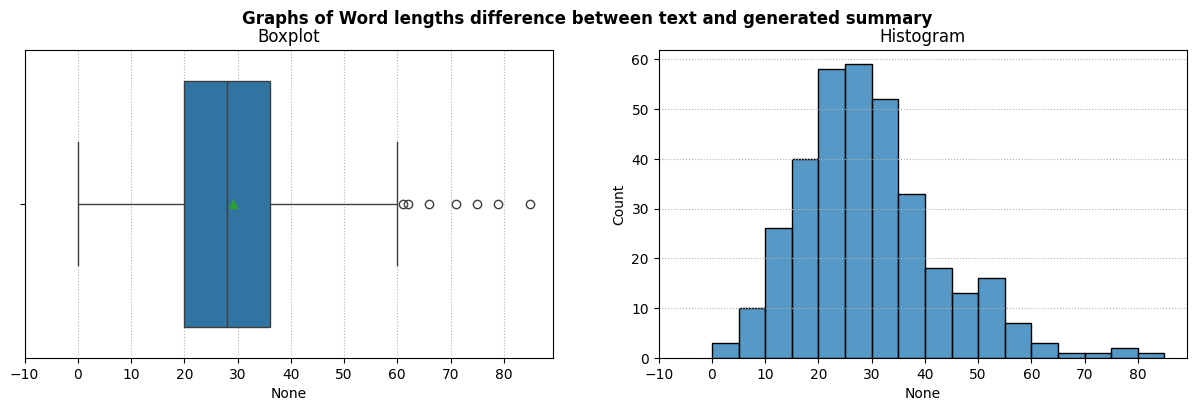

In [29]:
import seaborn as sns

_, ax = plt.subplots(1, 2, figsize=(15, 4))
plt.suptitle("Graphs of Word lengths difference between text and generated summary", fontweight="bold")

min_val = np.min(word_length_diff_ll)

sns.boxplot(x=word_length_diff_ll, showmeans=True, ax=ax[0])
ax[0].grid(axis="x", linestyle="dotted", linewidth=0.8, alpha=1)
ax[0].set_xticks( range( min_val-min_val%10-10, np.max(word_length_diff_ll) + 5, 10) )
ax[0].set_title("Boxplot")

sns.histplot(x=word_length_diff_ll, binwidth=5, ax=ax[1])
ax[1].grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
ax[1].set_xticks( range( min_val-min_val%10-10, np.max(word_length_diff_ll) + 5, 10) )
ax[1].set_title("Histogram")

plt.show()

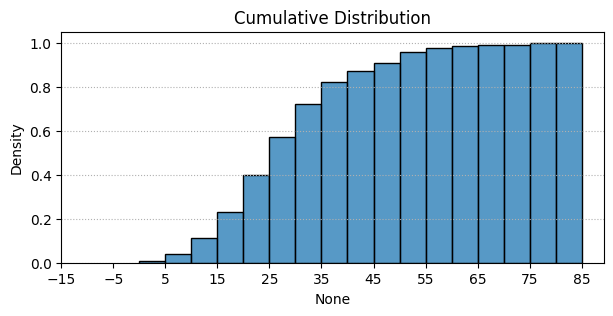

In [30]:
plt.figure(figsize=(7, 3))
plt.title("Cumulative Distribution")
sns.histplot(x=word_length_diff_ll, binwidth=5, kde=False, cumulative=True, stat="density")
plt.grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
plt.xticks( range( min_val-min_val%10-10-5, np.max(word_length_diff_ll) + 5, 10) )
plt.show()

<li>Almost all the generated summaries are smaller than the input text.</li>
<li>The mean and median of the length difference is around 26.</li>
<li>Most of the length differences are between 10 to 50.</li>

In [31]:
n1 = np.sum( np.array(word_length_diff_ll) <=0 )
n2 = len(word_length_diff_ll)
print("Total generated summaries with length greater than text: ", n1)
print("Total summaries: ", n2)
print("Ratio: ", n1/n2)

Total generated summaries with length greater than text:  2
Total summaries:  343
Ratio:  0.0058309037900874635
